#  Measuring Transcription Rate in *Drosophila* embryos

(c) 2016 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import skimage.io
import skimage.filters
import skimage.morphology
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('deep', color_codes=True)
%matplotlib inline

/Users/gchure/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


These data come from [Garcia et al. 2013](http://www.sciencedirect.com/science/article/pii/S0960982213011135) and were generously made available by Hernan Garcia directly. In this exercise, we will measure the rate of transcription in a nuclear cycle 14 of a developing *Drosophila melanogaster* embryo. Specificially, we are watching the beginning and end of transcription of the [Hunchback](https://en.wikipedia.org/wiki/Drosophila_embryogenesis#Maternal_effect_genes) morphogen. This was done in a particularly clever way by using the MS2 system to tag the 5' and 3' ends of the mRNA in *separate embryos*. In this experimental systems, fluorescent puncta appear when that region of the mRNA is properly transcribed. By watching the appearance of the relevant spots, we can make a measurement of the rate of transcription and investigate whether the timing makes sense, given the time in between nuclear divisions.

##  Developing an image processing pipeline

Before we can reach any quantitative biological conclusions, we first need to establish some way of measuring the number of spots in each image. Since we will have a (relatively) large image set, it is imperative that we perform this procedure without requiring any manual intervention. To begin, let's take a look at a few representative images and come up with a segmentation scheme. 

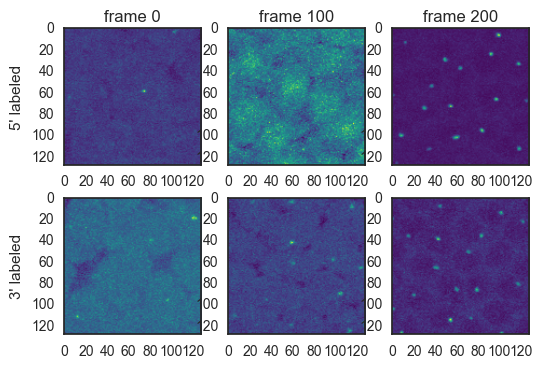

In [8]:
# Define the data directory and display some images.
data_dir = '../data/garcia_et_al_2013/'

# Scrape all of the file names
spots_5p_glob = glob.glob(data_dir + '5*.tif')  # 5' labeled mRNA
spots_3p_glob = glob.glob(data_dir + '3*.tif')  # 3' labeled mRNA
 
# Load in the images
spots_5p = skimage.io.ImageCollection(data_dir + '5*.tif')
spots_3p = skimage.io.ImageCollection(data_dir + '3*.tif')

# Show three frames from each.
fig, ax = plt.subplots(2, 3)
choice_images = [1, 101, 201]
for i, im in enumerate(choice_images):
    ax[0,i].imshow(spots_5p[im], cmap=plt.cm.viridis)
    ax[0,i].set_title('frame {0}'.format(im - 1 ))
    ax[1,i].imshow(spots_3p[im], cmap=plt.cm.viridis)
    
# Add some labels for clarity.
ax[0,0].set_ylabel("5' labeled")
ax[1,0].set_ylabel("3' labeled")


We can see from the representative images that spots seem to appear somewhere around frame 100 and are substantially brighter than the background. We have two strategies for developing some way of counting the number of puncta.

1. Apply an absolute threshold value to apply to each image. 
2. Compute threshold values from each image and remove incorrectly segmented background.

Note that there are assumptions about the data lumped into our first strategy. First, this is assuming that all spots will be much brighter than the background, depending on how strictly we impose our threshold. As transcription begins, the puncta may in fact be very dim, and will not be counted. Additionally, this approach assumes that illumination is even across frames and that photobleaching does not occur. While both of theses assumptions may be valid, it is important to mention them specifically. 

To begin, we'll try applying a single threshold value to each frame. Let's first examine frame 200 of the 5' labeled embryo.

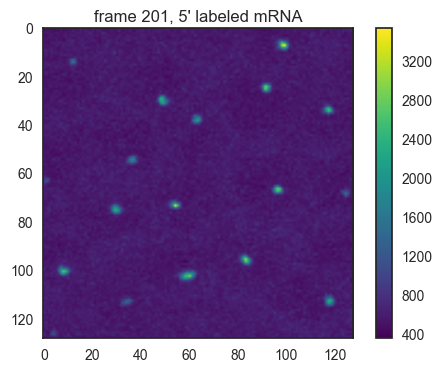

In [13]:
# Show only frame 200 of the 5' case.
plt.imshow(spots_5p[201], cmap=plt.cm.viridis)
plt.title("frame 201, 5' labeled mRNA")
plt.colorbar()

It appears that the background is *much* darker than the brightest spots. However, it is pretty difficult to draw a threshold just from looking at the image. What would be more useful is to look at the **histogram** of the image. In this approach, we can look at the distribution of pixel values and more intelligently choose our threshold value. 

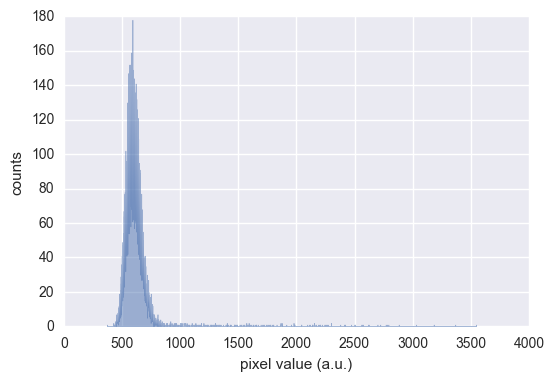

In [24]:
# Display the histogram of frame 200.
with sns.axes_style('darkgrid'):  # So we can see gridlines
    hist, bins = skimage.exposure.histogram(spots_5p[201])
    plt.fill_between(bins, hist, lw=0.5, alpha=0.5, color='b')
    plt.xlabel('pixel value (a.u.)')
    plt.ylabel('counts')

While a majority of the pixels are very dark (seemingly centered around ~600), there is a rather long tail of bright pixels showing up at a little bit before 1000 pixel counts. We can be a bit generous and choose to impose a threshold of 900. Let's see how this works on our image!

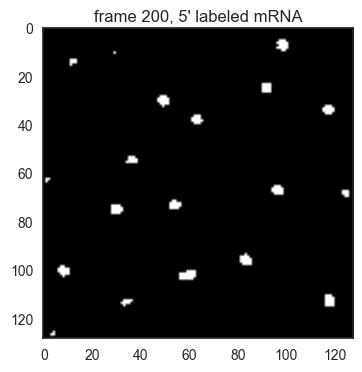

In [27]:
# Impose a pixel value threshold.
thresh = 900
plt.imshow(spots_5p[201] > thresh, cmap=plt.cm.Greys_r)
plt.title("frame 200, 5' labeled mRNA")

This seems to work pretty well, but there are a few hangups. First, it seems like we are actually catching a few pixels in the background which are not 'real' puncta. Secondly, our spots aren't very circular. Since we are not measuring the diameter of these puncta, we really only care about picking up background pixels.

There are a few ways in which we can correct for this problem. The first is by only counting segmented objects that meet a required size threshold. To do this in a fair way, we would have to look at the size distribution of a large number of these puncta to have a feeling for what would be a reasonable bound. Another stragegy would be to **filter** the image and remove any super-bright single pixels. We can do this using a median filter. Let's try filtering our image and displaying the resulting segmentation.

/Users/gchure/anaconda/lib/python3.4/site-packages/skimage/filters/rank/generic.py:68: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


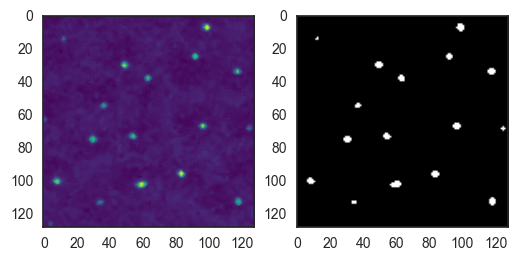

In [54]:
# Filter the image using a square shaped structuring element.
selem = skimage.morphology.square(3)
frame_filt = skimage.filters.median(spots_5p[201], selem=selem)

# Apply the threshold to the filtered image.
frame_thresh = frame_filt > thresh

# Display the resulting segmentation mask.
fig, ax = plt.subplots(1, 2)
ax[0].imshow(frame_filt, cmap=plt.cm.viridis)
ax[1].imshow(frame_thresh, cmap=plt.cm.Greys_r)

The median filtering did the trick! Now how many spots are present in this frame? Rather than counting each frame by hand, we can do this using the ``skimage.measure.label`` method packaged in the ``skiamge`` image processing modules. To verify the result, I counted the spots by hand and came up with 16 puncta visible to the naked eye.


There are 16 computer-visible puncta in this image.



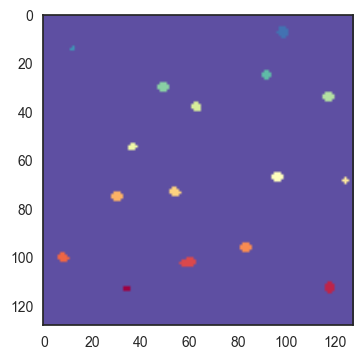

In [39]:
# Count the number of fluorescent puncta using labeling.
thresh_lab, num_spots = skimage.measure.label(frame_thresh, return_num=True)

# Print the number of spots and display the segmented image.
print("""
There are {0} computer-visible puncta in this image.
""".format(num_spots))

plt.imshow(thresh_lab, cmap=plt.cm.Spectral_r)

The computer also came up with 16 spots. Since this seems like a reasonable approach, let's write everything we have done as a function and apply it to the other images we showed at the beginning.

In [40]:
def spot_counter(im, thresh_val):
    """
    Counts the number of bright spots in a given image
    
    Parameters
    ----------
    im : 2d-array
        Image of interest.        
    thresh_val : int
        Threshold value to apply to the image.
        
    Returns
    -------
    im_lab : 2d-array, int
        Image with individually labeled objects.
    num_spots : int
        Number of spots in the supplied image. 
    """
    # Apply a median filter to the image.
    selem = skimage.morphology.square(3)
    im_filt = skimage.filters.median(im, selem)
    
    # Apply the threshold and label the image.
    im_thresh = im_filt > thresh_val
    im_lab, num_spots = skimage.measure.label(im_thresh, return_num=True)
    return im_lab, num_spots
    

/Users/gchure/anaconda/lib/python3.4/site-packages/skimage/filters/rank/generic.py:68: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


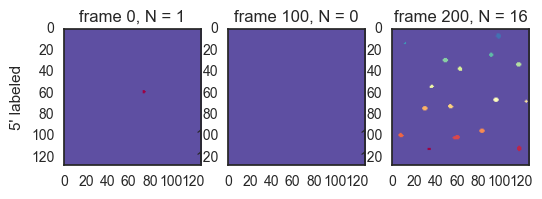

In [50]:
# Apply the function to our other frames.
fig, ax = plt.subplots(1, 3)
for i, im in enumerate(choice_images):
    lab_5p, num_5p_spots = spot_counter(spots_5p[im], 900)
    ax[i].imshow(lab_5p, cmap=plt.cm.Spectral_r)
    ax[i].set_title('frame {0}, N = {1}'.format(im - 1, num_5p_spots))
    
# Format the axes for clarity.
ax[0].set_ylabel("5' labeled")

##  Measuring transcription rate

It seems like we have a pipeline in place. Let's try this on all of the 5' labeled images and look at the number of spots as a function of time.

/Users/gchure/anaconda/lib/python3.4/site-packages/skimage/filters/rank/generic.py:68: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/Users/gchure/anaconda/lib/python3.4/site-packages/skimage/filters/rank/generic.py:68: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


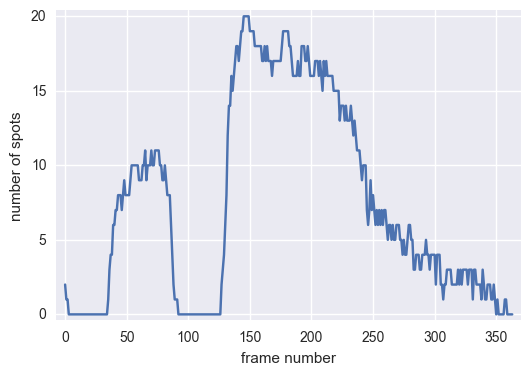

In [60]:
# Make a storage vector for the spot numbers.
num_5p_spots = np.zeros(len(spots_5p))

# Loop over each image and find the number of spots.
for i, im in enumerate(spots_5p):
    _, num_spots = spot_counter(im, 900)
    num_5p_spots[i] = num_spots
     
# Plot the result.
with sns.axes_style('darkgrid'):
    frames = np.arange(0, len(spots_5p), 1)
    plt.plot(frames, num_5p_spots, '-')
    plt.xlabel('frame number')
    plt.ylabel('number of spots')
    plt.margins(0.02)

From the above plot, we can see that there are two 'waves' of transcription for the 5' labeled mRNAs. These correspond to different nuclear division cycles. What is the most interesting to us, however, is looking at the time difference between the 5' and 3' labeled samples as that will give us an idea of the transcription rate. Since we wrote our image processing function in a flexible way, it can be easily applied to a completely different experimental run. The only thing we will have to change is by determining our threshold value for the 3' labeled data set. Let's take a quick look at the histogram and determine this value. 

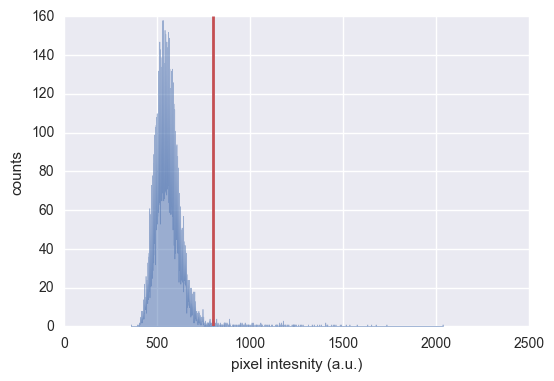

In [63]:
# Generate a histogram of the 3' labeled data.
with sns.axes_style('darkgrid'):
    hist, bins = skimage.exposure.histogram(spots_3p[201])
    plt.fill_between(bins, hist, color='b', lw=0.5, alpha=0.5)
    plt.xlabel('pixel intesnity (a.u.)')
    plt.ylabel('counts')
    ax = plt.gca()
    plt.vlines(800, 0, ax.get_ylim()[1], color='r', lw=2)

The threshold value of 800 a.u. is shown in red inthe above plot. While this approach is tractable for the small data set that we have, one can imagine doing this in an automated fashion for application of this procedure to very large data sets. 

With our 3' labeled sample threshold in place, we can do the same procedure as we did for the 5' labeled case. This time, we'll plot both traces on the same plot to make an estimate of the transcription rate by eye.

/Users/gchure/anaconda/lib/python3.4/site-packages/skimage/filters/rank/generic.py:68: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


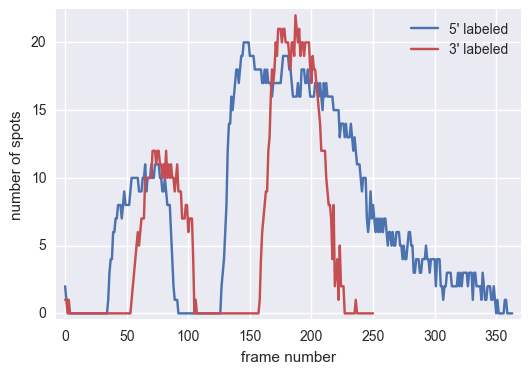

In [64]:
# Make a storage vector for the 3' labeled sample.
num_3p_spots = np.zeros(len(spots_3p))

# Loop over each image and find the number of spots.
for i, im in enumerate(spots_3p):
    _, num_spots = spot_counter(im, 800)
    num_3p_spots[i] = num_spots
     
# Plot the result.
with sns.axes_style('darkgrid'):
    frames_5p = np.arange(0, len(spots_5p), 1)
    frames_3p = np.arange(0, len(spots_3p), 1)
    plt.plot(frames_5p, num_5p_spots, 'b-', label="5' labeled")
    plt.plot(frames_3p, num_3p_spots, 'r-', label="3' labeled")
    plt.xlabel('frame number')
    plt.ylabel('number of spots')
    plt.margins(0.02)
    plt.legend()

It makes sense that the peak 3' signal should appear after the peak 5' signal knowing that mRNA is transcriped from the 5' to the 3' end. How can we get a rate from this plot? To attack this question, we will learn how to identify the 